# Group 36 Project Report

### Group Members: Bhavtej Bhasin, Peter Chen, Theresa Choi, Sky Langille
### DSCI 100 004

Please run the cell below to load the necessary libraries and the data set.

In [6]:
#loading libraries
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
install.packages("kknn")

#loading the dataset into R
university_data <- read_csv("World University Rankings 2023.csv")
university_data

## K-Nearest Neighbor Regression Model for University Ranking Based on the Ratio of Students per Staff Students.

**Introduction:**

Incoming university and high school students all over the world make their decision on which post-secondary institution to study at every year. Oftentimes these decisions are made on a number of factors, including the quality of teaching and programs offered, class size, geographical location, and often the rank and prestige of the university itself. Luckily, data sets with university ranking and a number of factors, those listed above and more, are readily available online. Here, we use the University Rankings 2023 data set publicly available on Kaggle, published by Syed Ali Taqi and edited by Abdullah Sajid and Muhammad Jawad Awan, to conduct data analysis on university ranking and the ratio of students per staff. More specifically, can the global ranking of a university institution be determined through a K-Nearest Neighbor Regression Model based on the ratio of students per staff member?

The University Rankings 2023 data set includes global rankings for over 1500 post secondary institutions globally, as well as statistics for each institution including:
- University Rank
- Number of students
- Number of students per staff
- International students
- Ratio of female and male students
- Overall Score
- Teaching score
- Research score
- Citations Score
- Industry Income Score
- International Outlook Score.

The names and locations of the universities are also listed in separate columns. Here we will only be using the University Rank, University Name and Number of students per staff columns in our analysis.

**Methods & Results:** - CANNOT BE IN BULLET POINTS

- Describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- Your report should include code which:
    - loads data from the original source on the web 
    - wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
    - performs the data analysis
    - creates a visualization of the analysis 

Before we can do any analysis on for the regression, we must take our original data set and perform an initial data wrangling to tidy up the necessary data and columns for our analysis. First things first, the original data set column names are not ideal for use as their spaces and capitalization are great for a final table, but hard to use in coding. Our first step below is thus to rename any columns we are using to fit our needs. These columns include the University Rank, Name of University, Number of Students and Number of Students per Staff columns from the original data set.

In [16]:
#rename relevant columns
university_rename <- university_data |>
    rename(
       "university_rank" = "University Rank",
        "name_of_university" = "Name of University",
        "number_of_students" = "No of student",
        "number_students_per_staff" = "No of student per staff"
    )

Now that we have renamed relevant columns to make them easier to work with, we can begin organizing our data set to fit out needs. We do not need all the columns from the original University Ranks 2023 data set, thus we will create a new data frame containing only the University Rank, Name of University, Number of Students and Number of Students per staff columns, which we renamed to university_rank, name_of_university, number_of_students and number_students_per_staff respectively. 

Not every university on the rankings list received a ranking, some only reported their statistics. We cannot use Reporter institutions for this analysis, only those with rankings, so we will filter the data set for only rows where university_rank is not "Reporter". Next, we filtered out institutions that did not provide a statistic for the number of students to staff by filtering for only complete cases in the number_students_per_staff column. Finally, we convert the university_rank column to be numeric variables rather than character variables and drop any rows where university rank is then not applicable, or NA.

Some universities only received rankings in a range such as "201-250" or "1500+". Ranges like these will be difficult to use in our data analysis, thus we will filter these rows out of the data set. However, this leaves us with a significantly small data set of 198 rows which is not ideal, thus future data analysis on University Rankings would be best performed on a larger list of subsequently ranked universities.

In [18]:
university_student_stats <- university_rename |> #create tibble with only relvant columns
    select(university_rank, name_of_university, number_of_students, number_students_per_staff) |>
    filter(university_rank != "Reporter") |> #filter out unranked universities
    filter(complete.cases(number_students_per_staff)) |> #filter out universities that did not report a student ratio
    mutate(university_rank = as.numeric(university_rank)) |>
    drop_na(university_rank) #filter out universities whose ranks are ranges (eg. 201-250)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `university_rank = as.numeric(university_rank)`.
Caused by warning:
! NAs introduced by coercion”


To finish up our initial data wrangling, we will create a new data frame with only the University Rank and Number of Students per Staff by selecting only these columns. Here we name this tibble "university_rank_students".

In [20]:
#separate tibble with only univeristy rank and number of students per staff.
university_student_ratio <- university_student_stats |> 
    select(university_rank, name_of_university, number_students_per_staff)

university_rank_students <- university_student_ratio |>
    select(university_rank, number_students_per_staff)
university_rank_students

university_rank,number_students_per_staff
<dbl>,<dbl>
1,10.6
2,9.6
3,11.3
3,7.1
5,8.2
⋮,⋮
196,43.4
196,15.8
198,14.1


Below we have generated a scatterplot visualization of University Rank against the Number of Students per Staff to demonstrate our original data before any analysis.

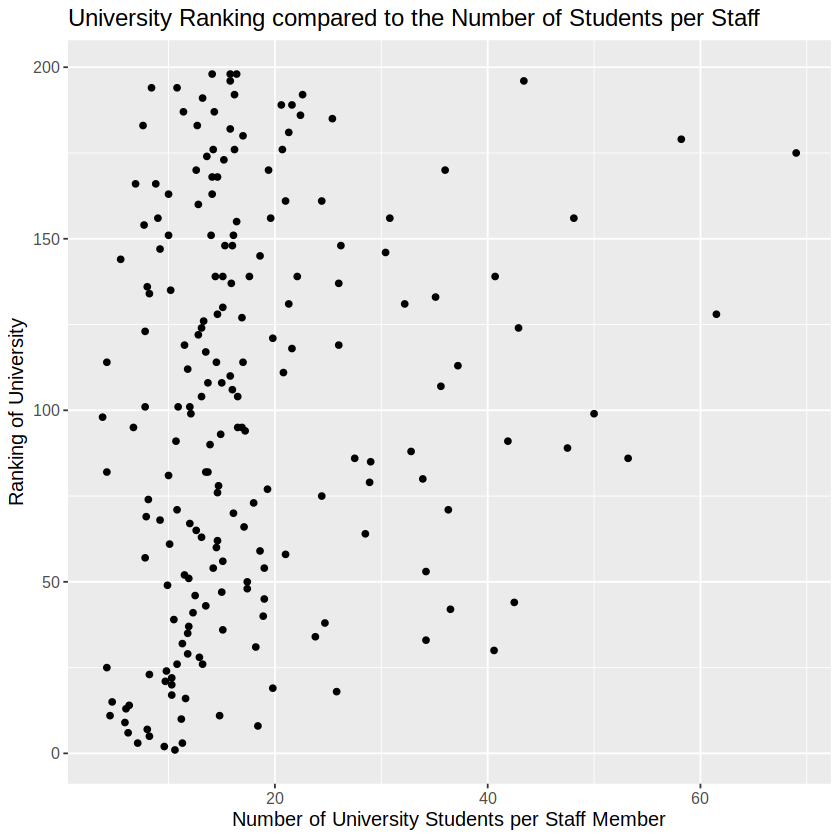

In [27]:
rank_student_plot <- university_rank_students |> 
    ggplot(aes(x = number_students_per_staff, y = university_rank)) +
    geom_point() +
    xlab("Number of University Students per Staff Member") +
    ylab("Ranking of University") +
    ggtitle("University Ranking compared to the Number of Students per Staff") +
    theme(text = element_text(size=12))
rank_student_plot

The plot above comparing University Ranking against their Number of Students per Staff Member shows the majority of the Number of Students per Staff is below approximately 30. However, a weak positive relationship can be seen just by visual inspection as a fair number of university rankings increase as the Number of Students per Staff Member increases. In the context of University Rankings, lower rankings (ie. 1, 2, 3 etc) are preferred to higher rankings (ie. 50, 60, 100).

Now that we have explored our original data set, we can begin our data analysis and beign creating a K-Nearest Neighbor Regression Model to predict University Ranking based on the Number of Students per Staff member. This begins with setting the seed to ensure analysis is replicable, then creating the testing and training data sets. This is seen in the code cell below:

In [26]:
set.seed(2023) #set seed DO NOT CHANGE!

university_split <- initial_split(university_rank_students, prop = 0.70, strata = university_rank)
university_training <- training(university_split)
university_testing <- testing(university_split)

**REVISE LATER**
Given our initial data set only contains 198 rows, we decided a 70-30 ratio split between the training and testing data sets would be appropriate to ensure enough data would be available to create an efficient and usable model. This leaves approximately 139 rows in the training data set. Below we have included a summarizing table showing the number of observations in the training data set and the average number of students per staff of training set data.

In [31]:
#summarize training set in one table
training_table <- university_training |>
    mutate(number_training_obs = nrow(university_training)) |>
    mutate(average_student_ratio = mean(number_students_per_staff)) |>
    select(number_training_obs, average_student_ratio) |>
    slice(1)
training_table

number_training_obs,average_student_ratio
<int>,<dbl>
139,16.40935


The training set data has 139 observations and an average Number of Students per Staff of 16.41. This demonstrates it is representative of our original data set and thus can be used to train our K-Nearest Neighbor Regression Model.

Next we will visualize the training set in a scatterplot graph below.

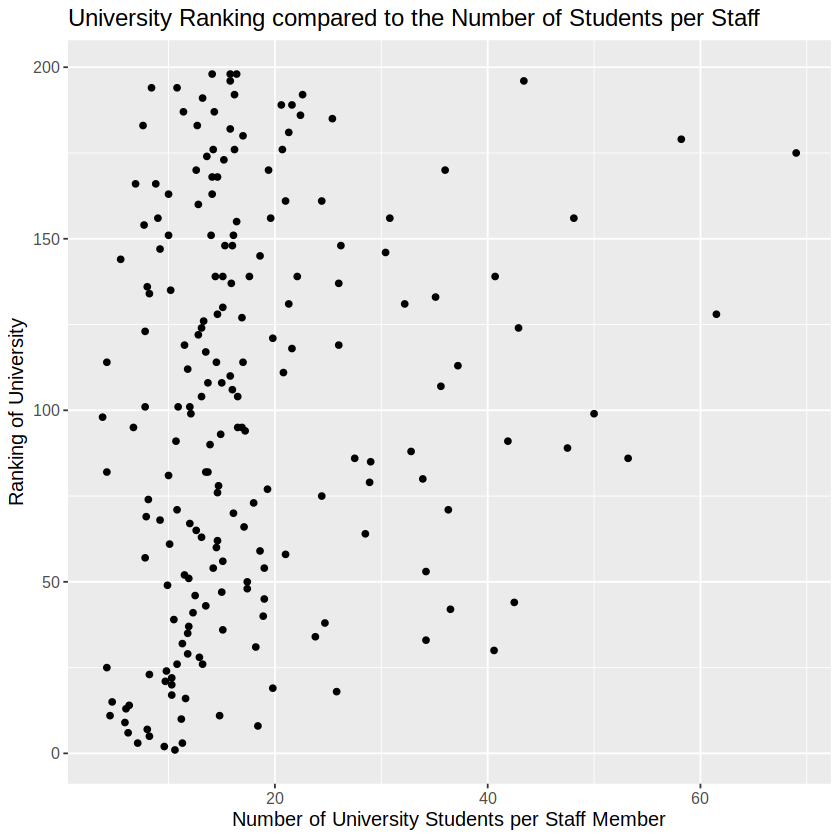

In [28]:
university_training_plot <- university_training |> 
    ggplot(aes(x = number_students_per_staff, y = university_rank)) +
    geom_point() +
    xlab("Number of University Students per Staff Member") +
    ylab("Ranking of University") +
    ggtitle("Plot of Training Set Data (University Rank vs. Number of Studnets per Staff)") +
    theme(text = element_text(size=12))
rank_student_plot

The plot above is fairly similar to the visualization of the original data set with a weak positive relationship between university ranking and the number of students per staff. As the number of students per staff increases, as does the university ranking, which in this case indicated the university ranking lower overall as university rankings function with 1 being the best and increasing numbers ranking below.

Now that we have separated and conducted some preliminary analysis of our training set, we can start building our regression model. This begins with setting the recipe and specs for our regression model as we have done in the cell below. Our recipe is set to determine University Rank based on the Number of Students per Staff variable from the training data set, with all predictors scaled. Our spec for this model has been set to tune as we will first tune the regression model to find the ideal K value with 5-Fold Cross Validation.

In [39]:
recipe <- recipe(university_rank ~ number_students_per_staff, data = university_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

spec <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

To create the best model possible using the ideal K-value, we will use 5-Fold Cross Validation to test K-values from # to #. Below we have set up the 5-Fold Cross Validation as well as the workflow for our regression model.

In [40]:
vfold <- vfold_cv(university_training, v = 5, strata = university_rank)

workflow <- workflow() |>
  add_recipe(recipe) |>
  add_model(spec)

workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Next we will perform the 5-Fold Cross Validation and collect the metrics for the Root Mean Squared Prediction Error (RMSPE) for the training data set, which is just the RMSE value collected by the collect_metrics function. Below we have generated a tibble showing the RMSE value for K-values 1 to 50.

In [46]:
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

results <- workflow |>
  tune_grid(resamples = vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

# show the regression results
results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,66.34726,5,3.649905,Preprocessor1_Model01
2,rmse,standard,58.26408,5,2.632500,Preprocessor1_Model02
3,rmse,standard,57.22648,5,1.861099,Preprocessor1_Model03
4,rmse,standard,54.92419,5,2.113997,Preprocessor1_Model04
5,rmse,standard,54.04868,5,1.642114,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
46,rmse,standard,55.86651,5,0.7691342,Preprocessor1_Model46
47,rmse,standard,55.83179,5,0.7173995,Preprocessor1_Model47
48,rmse,standard,55.87876,5,0.6864968,Preprocessor1_Model48


The ideal K-value to use would be the one which gives us the minimum RMSE value. We can find this K-value easily by filtering the mean column from the tibble above, which is the RMSE value, and pulling the value in the neighbors column associated with the observation with the lowest mean value we filtered for. This will give us our ideal K-value. 

In [56]:
kmin <- results |>
    filter(mean == min(mean)) |>
    pull(neighbors)
kmin

[1] 7

Performing the steps outlined above gives us an ideal K-value of $K = 7$. To confirm this, we can generate a plot visualizing the RMSE values from our 5-Fold Cross Validation. This is seen below in the plot titled "RMSE agains the Number of Neighbors used in Regression". Analyzing this plot we can see that 7 neighbors, or $K = 7$, is the ideal K-value. Visual inspection of the plot shows us that the minimum RMSE is obtained using $K = 7$.

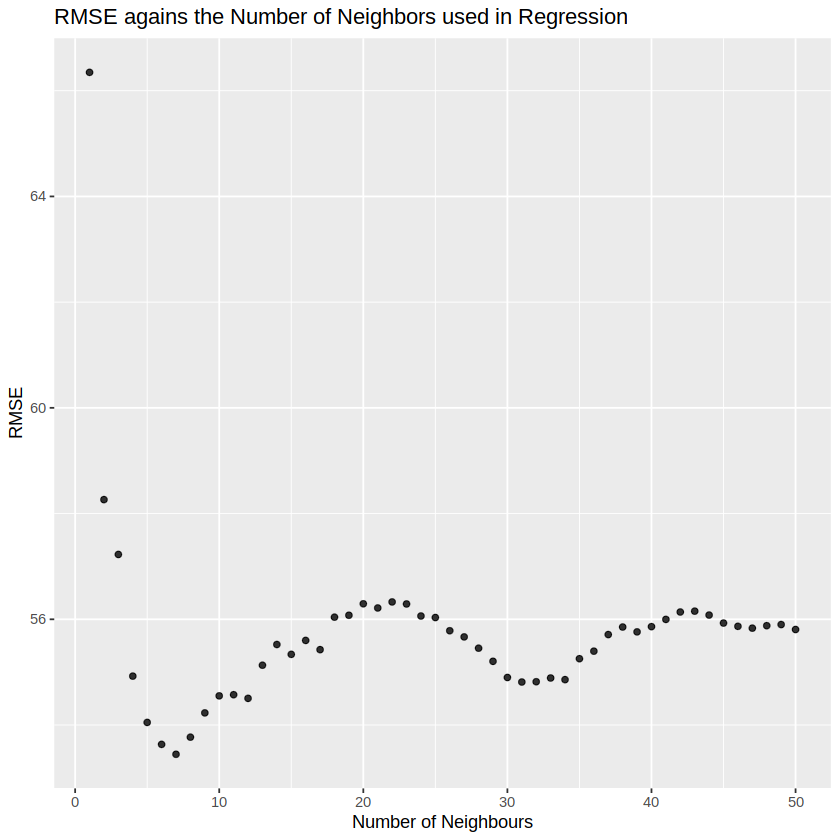

In [55]:
# plot the result (number of neighbours and RMSE score)
rmse_plot <- ggplot(results, aes(x = neighbors, y = mean)) +
    geom_point(alpha = 0.8) +
    xlab("Number of Neighbours") +
    ylab("RMSE") +
    ggtitle("RMSE agains the Number of Neighbors used in Regression")

rmse_plot

Now that we have determined $K=7$ to be our ideal K-value for our regression model, we can recreate our regression model with the determined number of neighbors and test it using the testing data set generated above, university_testing.

In [62]:
final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

final_fit <- workflow() |>
  add_recipe(recipe) |>
  add_model(final_spec) |>
  fit(data = university_training)

final_summary <- final_fit |>
  predict(university_testing) |>
  bind_cols(university_testing) |>
  metrics(truth = university_rank, estimate = number_students_per_staff) |>
  filter(.metric == 'rmse')

final_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,97.3266


.pred,number_students_per_staff
<dbl>,<dbl>
54.14286,4.2
156.71429,14.2
87.57143,24.2
88.14286,34.2
85.85714,44.2
102.57143,54.2


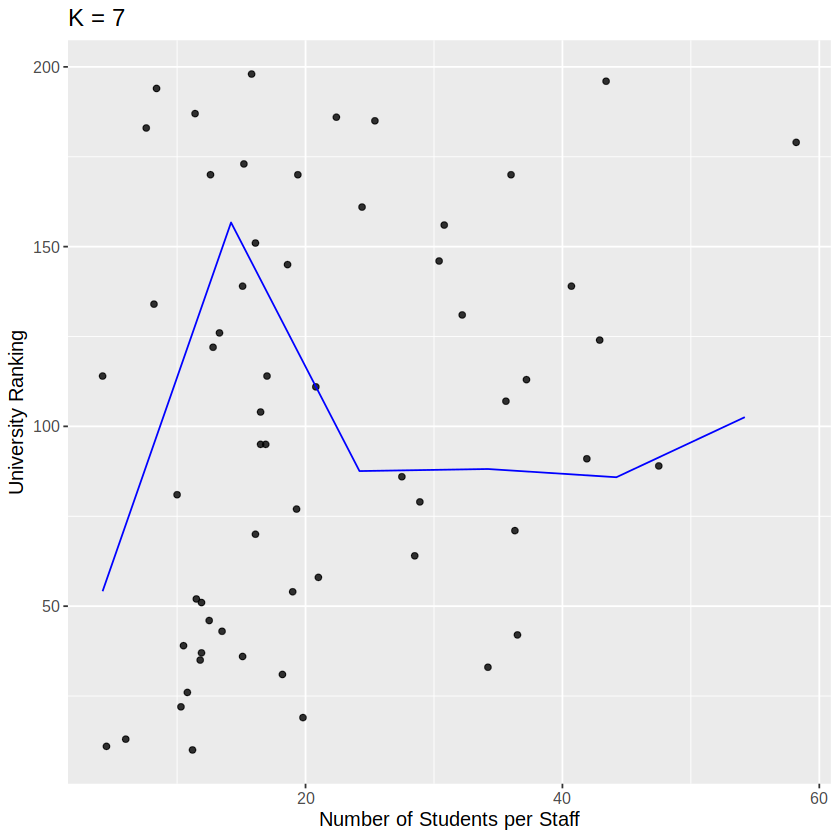

In [63]:
ranking_prediction_grid <- tibble(
    number_students_per_staff = seq(
        from =  university_testing |> select(number_students_per_staff) |> min(),
        to = university_testing |> select(number_students_per_staff) |> max(),
        by = 10
    )
)

rank_preds <- final_fit |>
  predict(ranking_prediction_grid) |>
  bind_cols(ranking_prediction_grid)
rank_preds

plot_final <- ggplot(university_testing, aes(x = number_students_per_staff, y = university_rank)) +
  geom_point(alpha = 0.8)+
  geom_line(data = rank_preds, 
            mapping = aes(x = number_students_per_staff, y = .pred), 
            color = "blue") +
  xlab("Number of Students per Staff") +
  ylab("University Ranking") +
  ggtitle(paste0("K = ", kmin)) + 
  theme(text = element_text(size = 12))

plot_final

**Discussion:** - CANNOT BE IN BULLET POINTS
- Summarize what you found
    - Discuss whether this is what you expected to find?
    - Discuss what impact could such findings have?
    - Discuss what future questions could this lead to?


**References:**
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).- 
- Make sure to cite the source of your data as well.